# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [49]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [50]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  



#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

            To create a home price estimate calculator. This value at Zillow is referred to as the "Zestimate".


**1.2:**  How will your solution be used?

            To generate home offers for employees at Zillow and encourage customers to use the website as a source of truth when buying or selling a home. 


**1.3:**  How should success (or failure) be measured?

            Proximity of Zestimate and real world sale prices would be the ultimate judge of success of the project. Consistently being far off of the sale data would mean that Zillow data analysts have failed in their primary objective.


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [51]:
print('Data Info')
print(df.info())
print('Data Description:')
print(df.describe())
print('Null Data:')
print(df.isnull().sum())

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  floa

In [52]:
missing_percent = df.isnull().sum() / len(df) * 100

missing_percent = missing_percent.sort_values(ascending=False)

print(missing_percent)

buildingclasstypeid             99.980673
finishedsquarefeet13            99.945885
basementsqft                    99.935578
storytypeid                     99.935578
yardbuildingsqft26              99.909809
fireplaceflag                   99.778388
architecturalstyletypeid        99.733292
typeconstructiontypeid          99.712677
finishedsquarefeet6             99.502661
pooltypeid10                    99.400874
decktypeid                      99.208895
poolsizesum                     98.880342
pooltypeid2                     98.616211
hashottuborspa                  98.017085
yardbuildingsqft17              96.916754
taxdelinquencyyear              96.263513
taxdelinquencyflag              96.263513
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedfloor1squarefeet        92.221664
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
pooltypeid7                     80.571554
poolcnt                         79

In [53]:
unique_counts = df.nunique().sort_values(ascending=False)

print(unique_counts)

parcelid                        77414
latitude                        64038
longitude                       62461
taxvaluedollarcnt               50949
rawcensustractandblock          39188
censustractandblock             39006
lotsizesquarefeet               18848
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
propertyzoningdesc               1907
finishedsquarefeet50             1807
finishedfloor1squarefeet         1787
finishedsquarefeet15             1724
garagetotalsqft                   839
yardbuildingsqft17                540
regionidneighborhood              480
regionidzip                       389
finishedsquarefeet6               350
poolsizesum                       262
regionidcity                      175
yearbuilt                         136
propertycountylandusecode          75
yardbuildingsqft26                 59
basementsqft                       43
bathroomcnt                        22
calculatedbathnbr                  21
bedroomcnt  

In [54]:
from sklearn.preprocessing import LabelEncoder

df1 = df.drop(columns=['parcelid', 'propertyzoningdesc', 'propertycountylandusecode',
                      'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock'])

for col in df1.select_dtypes(include=[np.number]).columns:
    df1[col] = df1[col].fillna(df1[col].median())

X = df1.drop(columns=['taxvaluedollarcnt'])
y = df1['taxvaluedollarcnt']

for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = X[col].astype(str)

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna('Unknown')


for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])




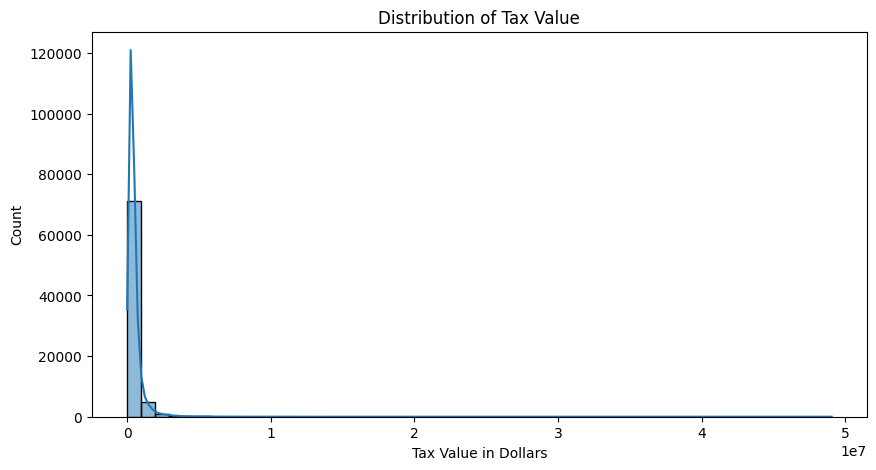

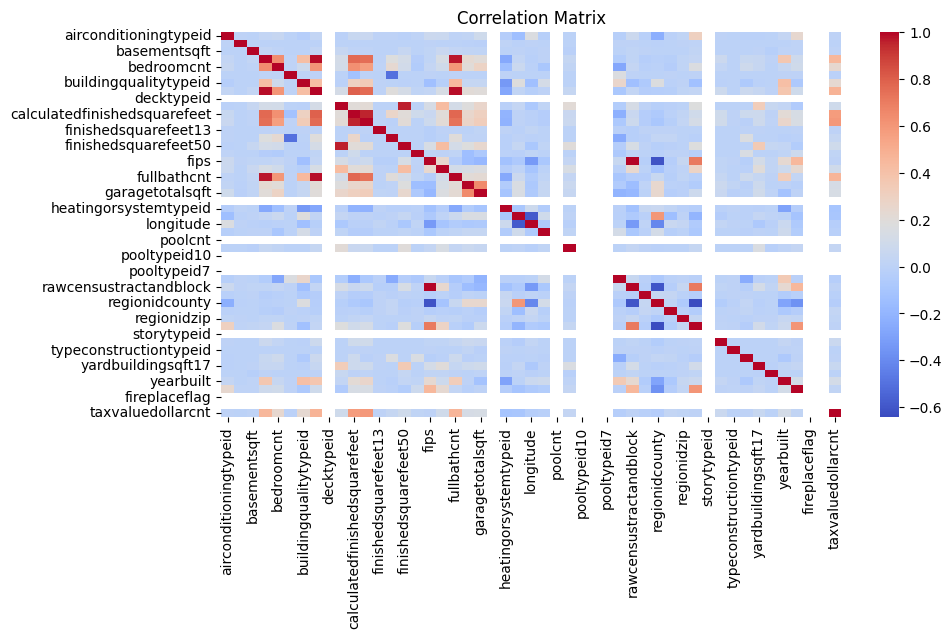

In [55]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

plt.figure(figsize=(10,5))
sns.histplot(df1['taxvaluedollarcnt'].dropna(), bins=50, kde=True)
plt.title('Distribution of Tax Value')
plt.xlabel('Tax Value in Dollars')
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(df1.corr(), cmap="coolwarm", annot=False)
plt.title('Correlation Matrix')
plt.show()

In [56]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print('\nLinear Regression Results:')
print('R^2:', r2_score(y_test, y_pred_lr))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression Results:
R^2: 0.41715808361836004
RMSE: 480431.24187812436


In [57]:
df1.corr()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxvaluedollarcnt
airconditioningtypeid,1.000000,0.006578,-0.000902,0.029044,0.051506,0.000544,-0.036931,0.028000,NaN,-0.006800,...,0.006721,-0.000590,-0.007847,-0.006030,-0.001207,0.037731,0.240340,NaN,NaN,0.002356
architecturalstyletypeid,0.006578,1.000000,-0.000043,-0.003176,-0.004478,0.000026,-0.001773,-0.003357,NaN,-0.000326,...,-0.000212,-0.000028,-0.000553,-0.000289,-0.000058,0.000297,0.008633,NaN,NaN,-0.001809
basementsqft,-0.000902,-0.000043,1.000000,0.026358,0.012771,0.000021,-0.001453,0.026819,NaN,0.051654,...,-0.000173,-0.000023,-0.000453,0.004272,-0.025541,0.008076,0.009088,NaN,NaN,0.009261
bathroomcnt,0.029044,-0.003176,0.026358,1.000000,0.635473,0.008279,0.418265,0.984360,NaN,0.120403,...,0.077161,0.000353,0.052119,0.049530,0.004023,0.369876,0.084207,NaN,NaN,0.461026
bedroomcnt,0.051506,-0.004478,0.012771,0.635473,1.000000,0.009612,0.084496,0.607454,NaN,0.114599,...,0.032352,-0.000939,0.084563,0.051105,-0.002884,0.046943,0.101490,NaN,NaN,0.239324
buildingclasstypeid,0.000544,0.000026,0.000021,0.008279,0.009612,1.000000,0.000876,0.001154,NaN,0.000161,...,0.000105,0.000014,0.000273,0.000143,0.000029,0.006593,0.001116,NaN,NaN,-0.008695
buildingqualitytypeid,-0.036931,-0.001773,-0.001453,0.418265,0.084496,0.000876,1.000000,0.421654,NaN,-0.010951,...,-0.007112,-0.000950,-0.068183,-0.009711,-0.001943,0.414565,-0.076033,NaN,NaN,0.236997
calculatedbathnbr,0.028000,-0.003357,0.026819,0.984360,0.607454,0.001154,0.421654,1.000000,NaN,0.124088,...,0.078325,0.000299,0.076626,0.050529,0.003983,0.373180,0.096148,NaN,NaN,0.476774
decktypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
finishedfloor1squarefeet,-0.006800,-0.000326,0.051654,0.120403,0.114599,0.000161,-0.010951,0.124088,NaN,1.000000,...,-0.001307,-0.000174,-0.003507,0.329881,0.053343,0.031787,-0.059388,NaN,NaN,0.095270


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

            AC type, architectural style, building clas, building quality, deck type, fips, fireplace, hot tub, heating system, land use, zoning, every region code(4), tax ID.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 
               
                Parcel ID: buyers do not care what their property ID is
                Tax Delinquency (year and flag): being delinquent does not affect home value
                Neighborhood ID: may be too granular
                Census Data: may be too granular
                Zoning: too many unique values and typically does not matter to buyers


**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

            Anything above 30% is pretty unusable for our purposes.

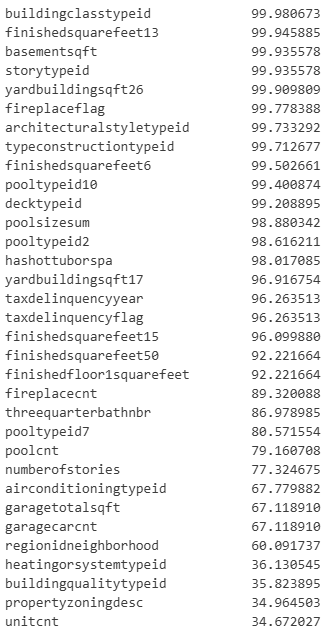

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 
            
            Assessment year is the first one that out. Only having one value makes it pretty useless.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

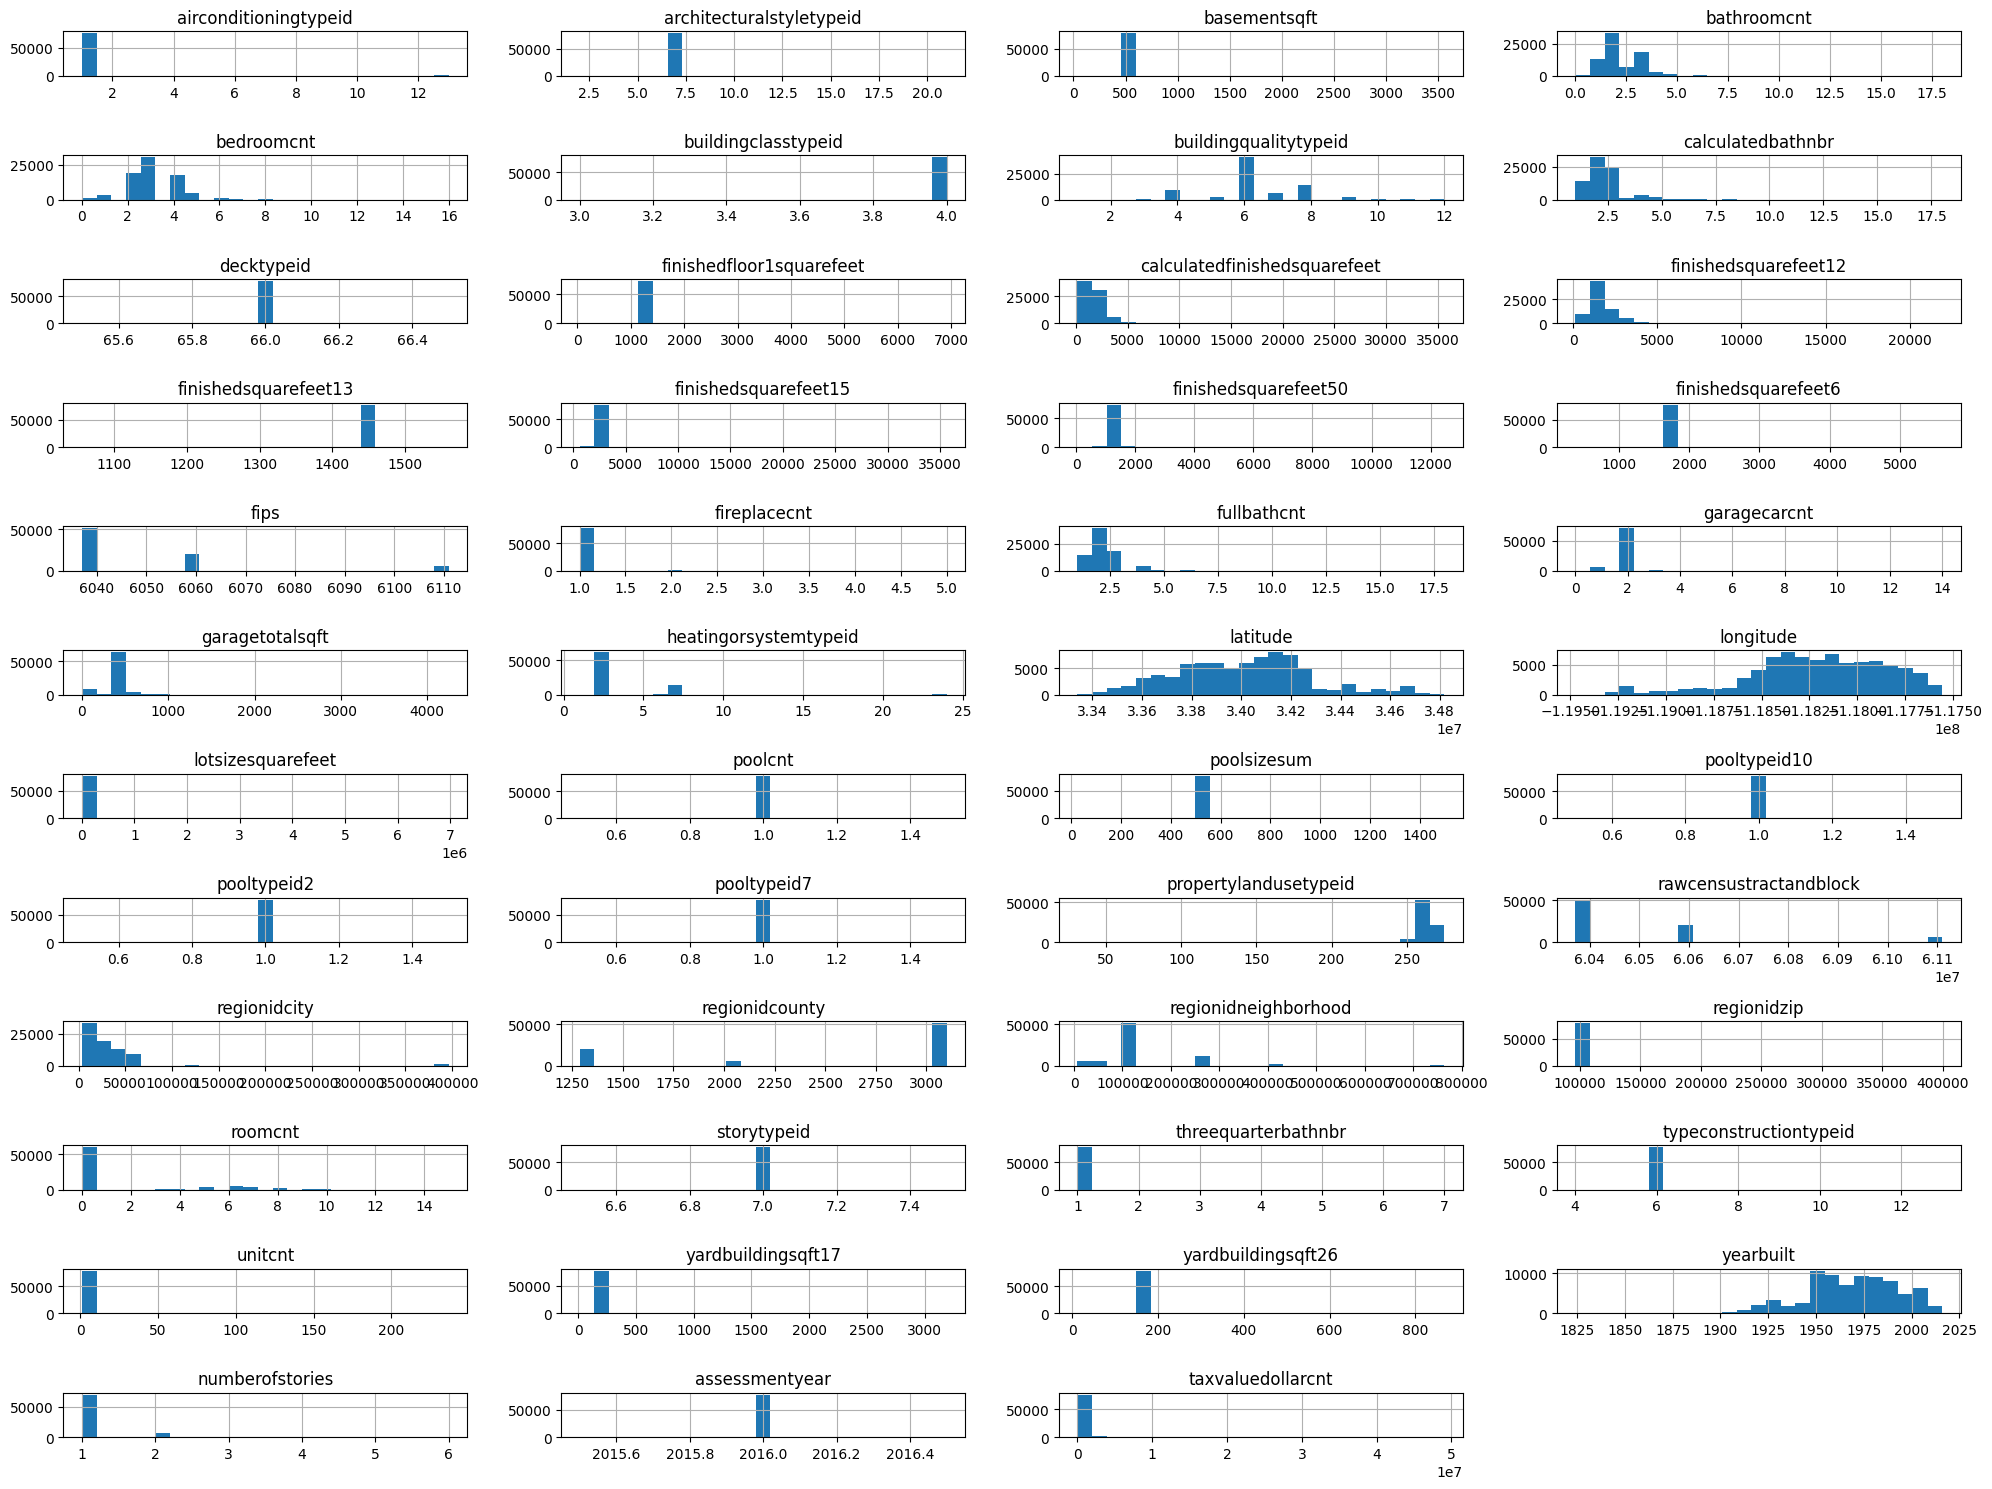

In [58]:
#plot histograms
df1.hist(figsize=(20, 15), bins=25, layout=(-1, 4))
plt.tight_layout()
plt.show()

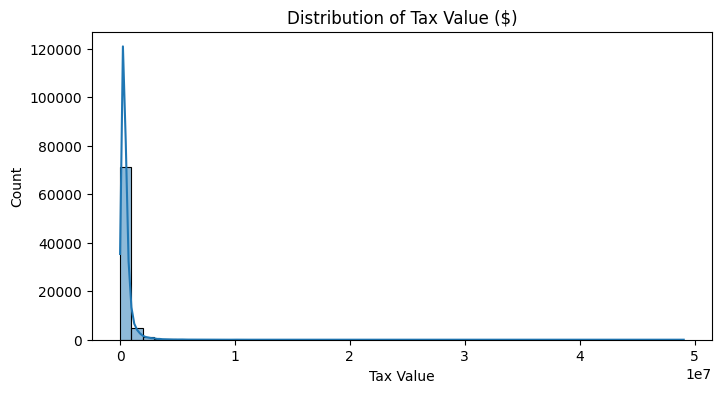

In [59]:
#home value distribution
plt.figure(figsize=(8, 4))
sns.histplot(df1['taxvaluedollarcnt'], bins=50, kde=True)
plt.title('Distribution of Tax Value ($)')
plt.xlabel('Tax Value')
plt.ylabel('Count')
plt.show()

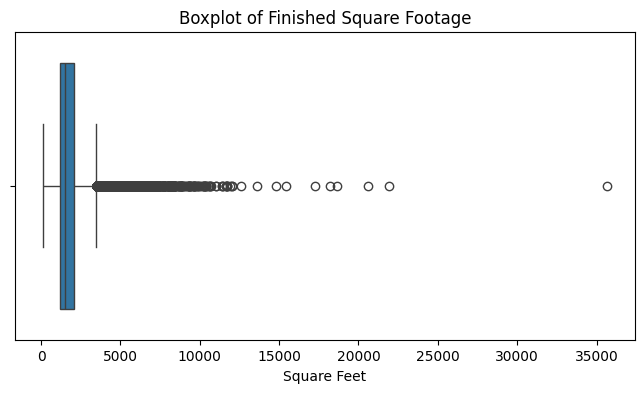

In [60]:
#boxplot of sqft statistics
plt.figure(figsize=(8, 4))
sns.boxplot(x=df1['calculatedfinishedsquarefeet'])
plt.title('Boxplot of Finished Square Footage')
plt.xlabel('Square Feet')
plt.show()


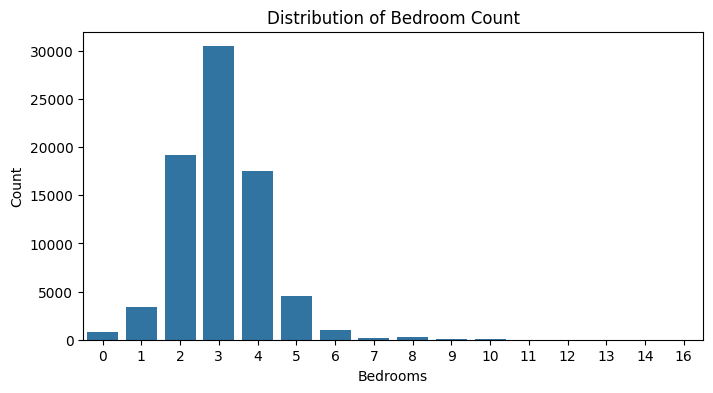

In [61]:
#bedroom count histogram
plt.figure(figsize=(8, 4))
sns.countplot(x=df1['bedroomcnt'].astype(int))
plt.title('Distribution of Bedroom Count')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()


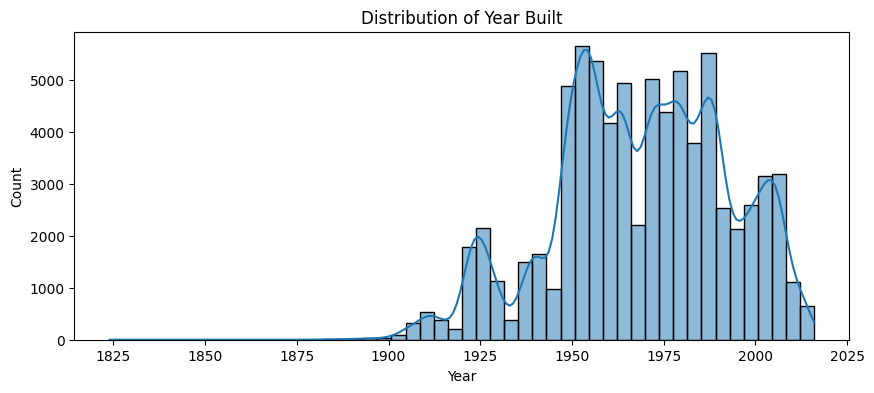

In [62]:
#year built distribution
plt.figure(figsize=(10, 4))
sns.histplot(df1['yearbuilt'].dropna(), bins=50, kde=True)
plt.title('Distribution of Year Built')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


        The distribution for home values is heavily skewed towards the right. This means that most datapoints are cheaper homes rather than more expensive ones. Another reason for this is outliers. The more expensive homes are definitely outliers and may need to be cut for a more effective model. Square footage suffers from a similar issue which makes sense since these two things tend to correlate heavily. Finally, for any features that we would like to keep that have missing values, an imputer will be needed to handle the data properly.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [63]:
df_cleaned = df.drop(columns=[
    'parcelid',
    'propertyzoningdesc',
    'propertycountylandusecode',
    'taxdelinquencyflag',
    'taxdelinquencyyear',
    'censustractandblock',
    'rawcensustractandblock',
    'latitude',
    'longitude'
])

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 

Many of these features are arbitrary or simply do not affect sale price. For instance, parcel ID does not is an arbitrary number assigned by the county and hasno real world consequence to buyers. Latitude and longitude represent location but it would be impossible to represent them with a regression model as desirable or indesirable locations are distributed much too chaotically for regression to handle. The county tax information columns will also not mean anything to buyers at all. They simply do not care what code the county assigns to their home or if the previous owner was tax delinquent.


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [64]:
missing_percent = df_cleaned.isnull().mean()

drop_nulls = missing_percent[missing_percent > .3].index.tolist()

df_dropped_nulls = df_cleaned.drop(columns=drop_nulls)



#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped

        This is a tough decision as it is nice to have as much data as possible but also it is very difficult to work with massive holes in the data. 30% is nearly a third and it would be difficult to rely on data that is imputed as it could be wildly wrong. Since the dataset is large, using a stricter selection means the data will be more accurate.


### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [65]:
df_dropped = df_dropped_nulls[df_dropped_nulls['taxvaluedollarcnt'].notnull()]

row_threshold = int(df_dropped.shape[1] * 0.7)
df_dropped = df_dropped[df_dropped.count(axis=1) >= row_threshold]

quant = df_dropped['taxvaluedollarcnt'].quantile(0.99)
df_dropped = df_dropped[df_dropped['taxvaluedollarcnt'] <= quant]

print(df_dropped)

       bathroomcnt  bedroomcnt  calculatedbathnbr  \
0              3.5         4.0                3.5   
1              1.0         2.0                1.0   
2              2.0         3.0                2.0   
3              3.0         4.0                3.0   
4              3.0         3.0                3.0   
...            ...         ...                ...   
77608          3.0         3.0                3.0   
77609          2.0         2.0                2.0   
77610          2.0         4.0                2.0   
77611          1.0         3.0                1.0   
77612          2.0         3.0                2.0   

       calculatedfinishedsquarefeet  finishedsquarefeet12    fips  \
0                            3100.0                3100.0  6059.0   
1                            1465.0                1465.0  6111.0   
2                            1243.0                1243.0  6059.0   
3                            2376.0                2376.0  6037.0   
4                 

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped

I chose to remove any where home value is missing as that is simply a useless column for our purposes. I chose to keep any rows that have more than 70% non-null values as this drops rows that have a lot of missing or useless data. The last bit also drops extreme outliers and should help make the model fit the majority of homes better.


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [66]:
for col in df_dropped.select_dtypes(include=['float64', 'int64']).columns:
    df_dropped[col] = df_dropped[col].fillna(df_dropped[col].median())

for col in df_dropped.select_dtypes(include=['object']).columns:
    df_dropped[col] = df_dropped[col].fillna(df_dropped[col].mode()[0])


print(df_dropped.isnull().sum().sum())

0


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset

        For numerical values, I used median as it is less sensitive to outliers. For categorical, features I chose mode to choose the most frequent data category. For binary values, I would have filled missing values with a "0" but there are already no null values left in the dataset.


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

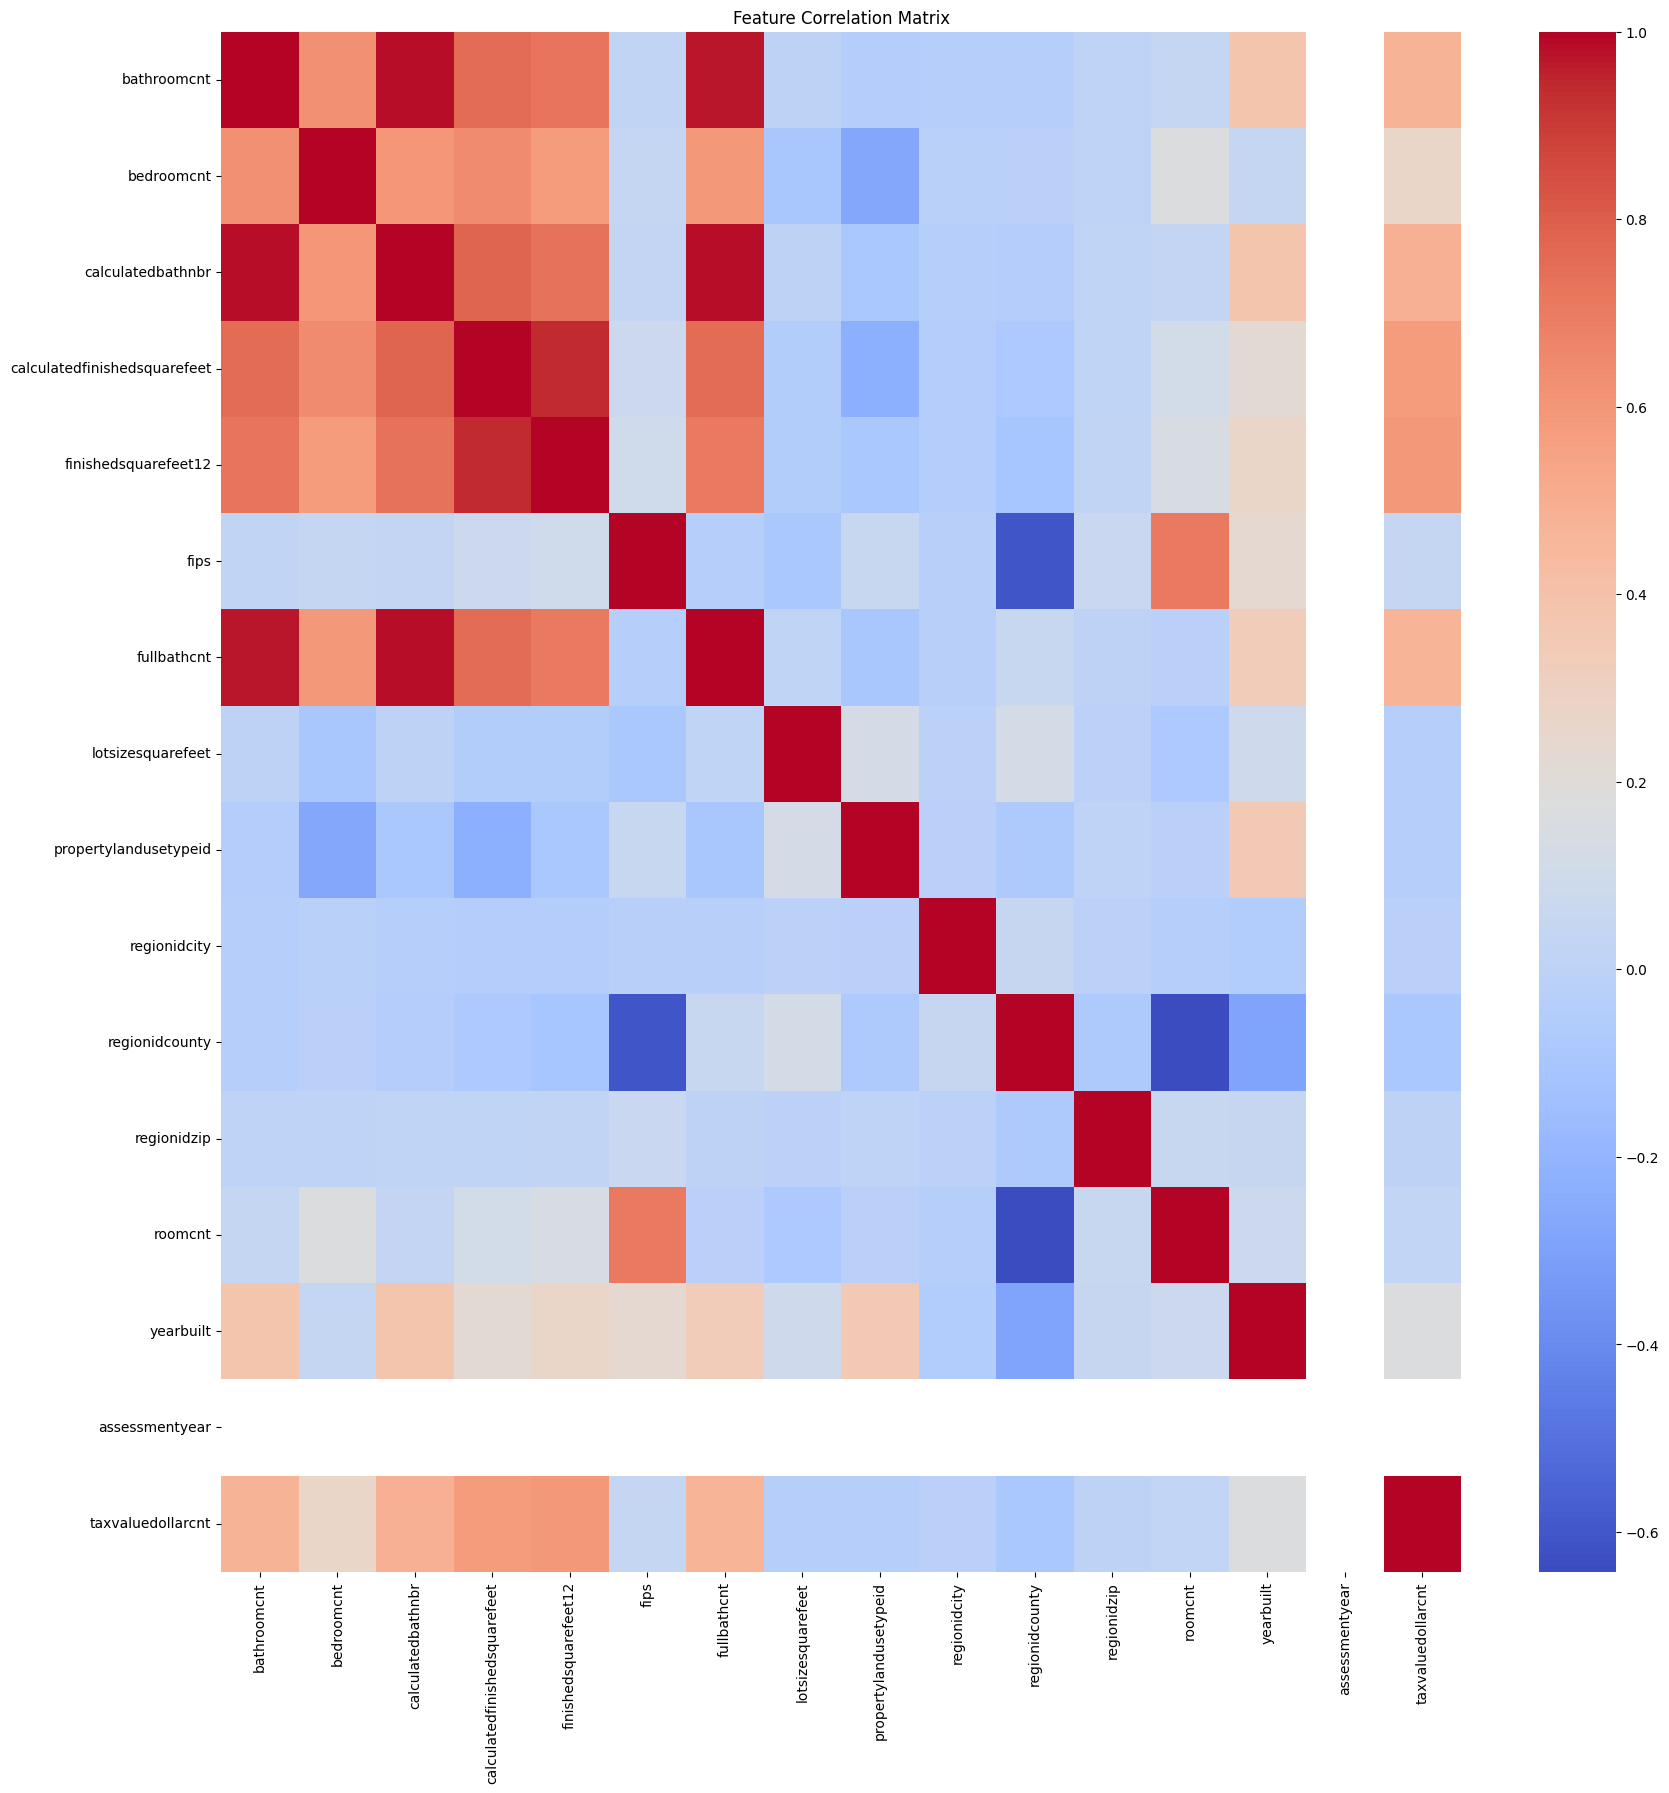

In [67]:

#correlation matrix
corr_matrix = df_dropped.corr(numeric_only=True)

#plot heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

In [68]:

#correlation analysis
top_corrs = corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)
print('Top correlations with taxvaluedollarcnt:\n', top_corrs.head(10))
print('\nNegative correlations:\n', top_corrs.tail(5))

Top correlations with taxvaluedollarcnt:
 taxvaluedollarcnt               1.000000
finishedsquarefeet12            0.591053
calculatedfinishedsquarefeet    0.578299
calculatedbathnbr               0.490330
bathroomcnt                     0.477844
fullbathcnt                     0.468799
bedroomcnt                      0.264363
yearbuilt                       0.171249
fips                            0.038354
roomcnt                         0.025577
Name: taxvaluedollarcnt, dtype: float64

Negative correlations:
 regionidcity            -0.019032
propertylandusetypeid   -0.037074
lotsizesquarefeet       -0.038427
regionidcounty          -0.088412
assessmentyear                NaN
Name: taxvaluedollarcnt, dtype: float64


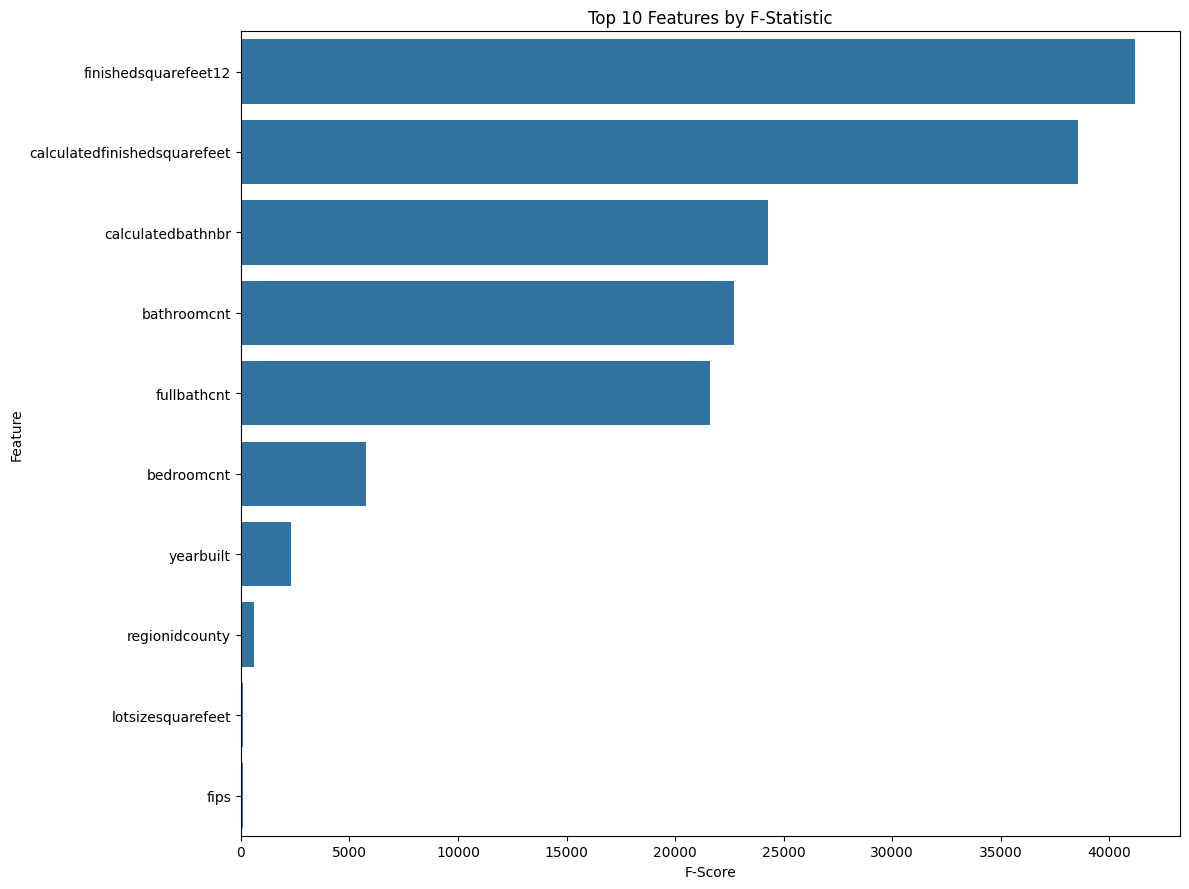

In [69]:

#f-statistics
X = df_dropped.drop(columns=['taxvaluedollarcnt'])
y = df_dropped['taxvaluedollarcnt']

f_scores, p_values = f_regression(X, y)

f_stats_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'P-Value': p_values})
f_stats_df = f_stats_df.sort_values(by='F-Score', ascending=False)

plt.figure(figsize=(12, 9))
sns.barplot(data=f_stats_df.head(10), x='F-Score', y='Feature')
plt.title('Top 10 Features by F-Statistic')
plt.tight_layout()
plt.show()

In [ ]:

model = LinearRegression()

#forward selection
forward = SequentialFeatureSelector(model, n_features_to_select=10, direction='forward')
forward.fit(X, y)
forward_selected = X.columns[forward.get_support()]
print('Forward Selected Features:', list(forward_selected))

Forward Selected Features: ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'propertylandusetypeid', 'regionidcounty', 'roomcnt', 'yearbuilt']


In [ ]:

#backward selection
backward = SequentialFeatureSelector(model, n_features_to_select=10, direction='backward')
backward.fit(X, y)
backward_selected = X.columns[backward.get_support()]
print('Backward Selected Features:', list(backward_selected))

Backward Selected Features: ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt', 'lotsizesquarefeet', 'propertylandusetypeid', 'regionidcounty', 'roomcnt', 'yearbuilt']


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?

        For the most part, these models agree. It is interesting to see calculated bath count and full bath count being in either list and exclusive. Many of the features above are heavily correlated, such as the 3 bathroom count measures. Another pair of features above are the two square footage statistics above.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

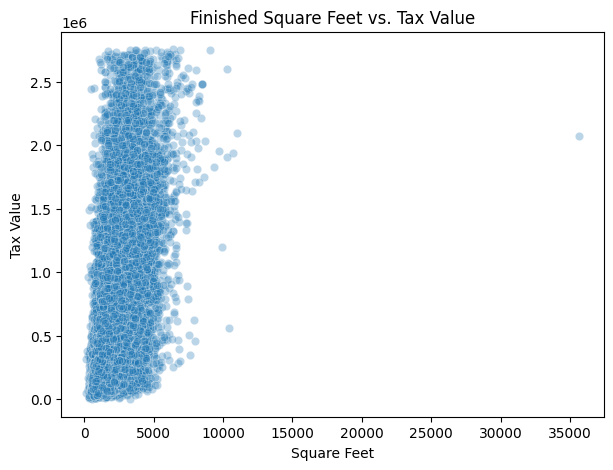

In [74]:

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_dropped, x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', alpha=0.3)
plt.title('Finished Square Feet vs. Tax Value')
plt.xlabel('Square Feet')
plt.ylabel('Tax Value')
plt.show()


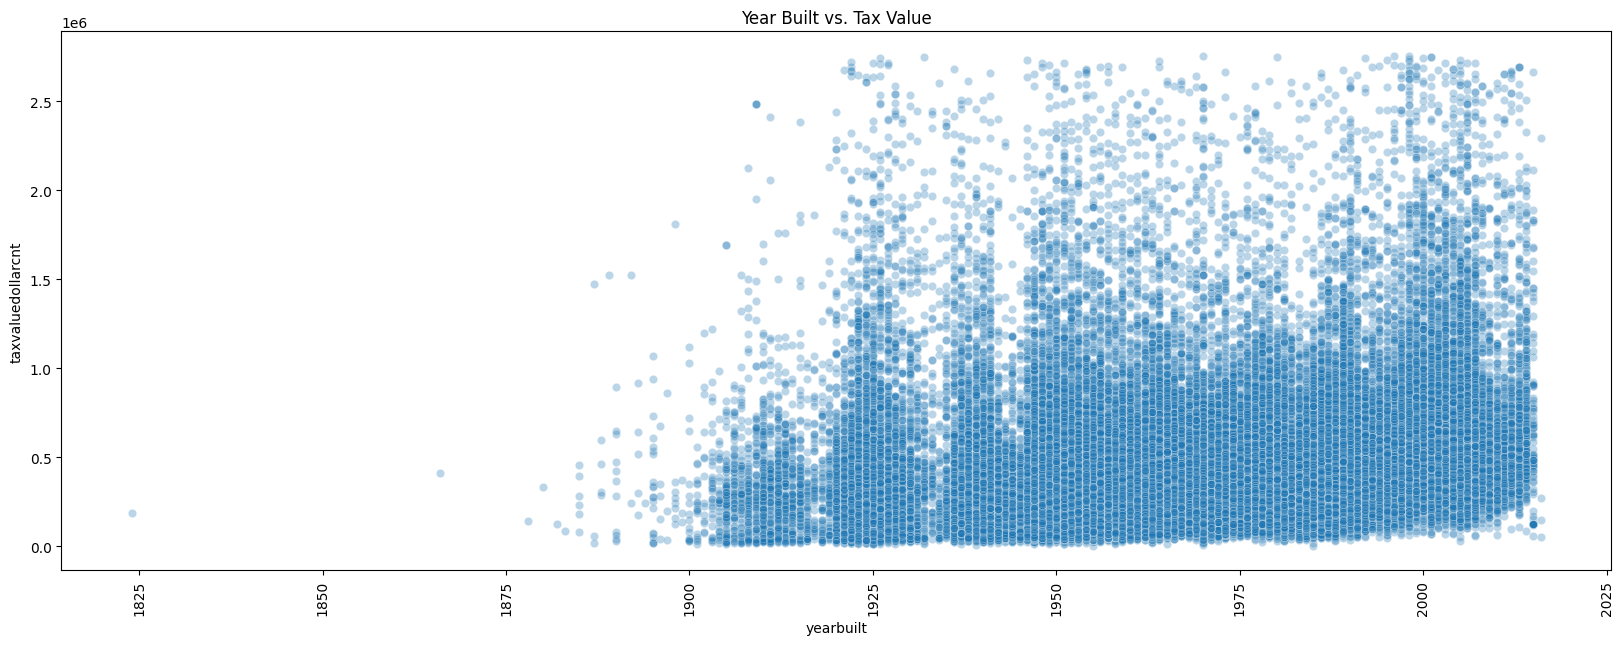

In [78]:

plt.figure(figsize=(20, 7))
sns.scatterplot(x='yearbuilt', y='taxvaluedollarcnt', data=df_dropped, alpha=0.3)
plt.xticks(rotation=90)
plt.title('Year Built vs. Tax Value')
plt.show()


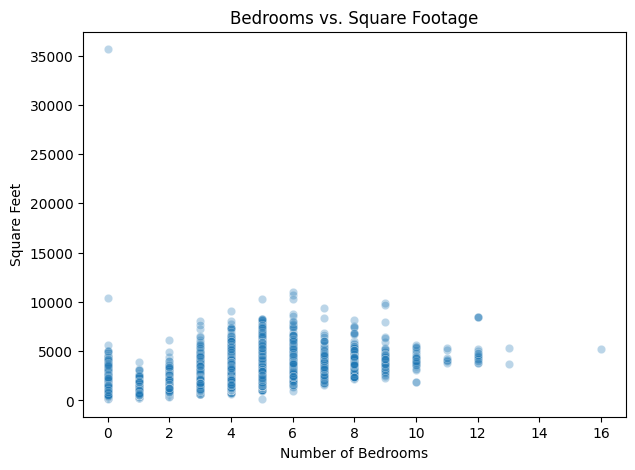

In [79]:

plt.figure(figsize=(7, 5))
sns.scatterplot(x='bedroomcnt', y='calculatedfinishedsquarefeet', data=df_dropped, alpha=0.3)
plt.title('Bedrooms vs. Square Footage')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Square Feet')
plt.show()


#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.

        The first plot shows a clear, positive correlation between square footage and home value. The second graph shows the relationship with the year a house is built and its sale value. A clear pattern emerges where newer homes are typically values higher than older homes. Finally, the last plot shows the postive correlation between square footage and bedroom count (with an obvious outlier).

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [ ]:
df_engineered = df_dropped.copy()
df_engineered['log_taxvaluedollarcnt'] = np.log1p(df_engineered['taxvaluedollarcnt'])

df_engineered['bedroomcnt_squared'] = df_engineered['bedroomcnt'] ** 2
df_engineered['sqft_per_room'] = df_engineered['calculatedfinishedsquarefeet'] / (df_engineered['roomcnt'] + 1)

X_engineered = df_engineered.drop(columns=['taxvaluedollarcnt'])  # using original target
y_engineered = df_engineered['taxvaluedollarcnt']

f_scores, _ = f_regression(X_engineered, y_engineered)
fs_df = pd.DataFrame({'Feature': X_engineered.columns, 'F-Score': f_scores})
print(fs_df.sort_values(by='F-Score', ascending=False).head(10))

                         Feature        F-Score
15         log_taxvaluedollarcnt  207318.244467
4           finishedsquarefeet12   41188.394403
3   calculatedfinishedsquarefeet   38546.633293
2              calculatedbathnbr   24281.785163
0                    bathroomcnt   22699.609456
6                    fullbathcnt   21608.652671
17                 sqft_per_room   16610.796718
1                     bedroomcnt    5764.199102
16            bedroomcnt_squared    5059.195108
13                     yearbuilt    2317.691705


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


        I chose a logarithmic transformation on the target variable to attempt to decrease the skew and increase model accuracy. This proved to be very effective accprding to the F-scores. The attempt to correlate bedroom count and finished square footage proved very helpful as well if this is at all accurate. This makes sense as larger bedrooms are more valuable for home owners. The strong correlation showed makes this a potentially valuable feature. Finally, the squared rooms feature was not particularly useful but it is good to know that a nonlinear model did not improve the accuracy.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

